Testing robust background estimation methods
----------

This notebook is an attempt to devise a test of robust background estimation methods on simulated data. To simplify the calculations, all the arrays are one dimensional. 

The "sky" consists of three components:

 * clean pixels whose values are drawn from a normal distribution with a mean of 100 plus a small offset and small sigma
 * "hot pixels" drawn from a lognormal distribution with a fairly low mean (~10) and with a broad sigma 
 * "cosmic rays" drawn from a lognormal distribution with a fairly high mean (1000) and narrower sigma.
 
In the experiment at the end of the notebook there is also a "source"

 * Source flux = 1000 spread over 5 pixels
 
We try versions with and without quantization. In the case of quantization, we turn everything to integers before calculating any of the statistical quantities.

In [374]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import ofiltsky
from astropy.stats import sigma_clipped_stats

%matplotlib inline

Sky background
---

The "sky" consists of three components:

 * clean pixels whose values are drawn from a normal distribution with a mean of 100 plus a small offset and small sigma
 * "hot pixels" drawn from a lognormal distribution with a fairly low mean (~10) and with a broad sigma 
 * "cosmic rays" drawn from a lognormal distribution with a fairly high mean (1000) and narrower sigma.

In [220]:
def cleansky(mean=100.,sigma=1.,offset=0.,nsamp=100000):
    return stats.norm(loc=mean+offset,scale=sigma).rvs(nsamp)
def hotpix(mean=np.log(10.),sigma=2.,nsamp=100000):
    return np.random.lognormal(mean=mean,sigma=sigma,size=nsamp)
def cosmicray(mean=np.log(1000.),sigma=1.,nsamp=100000):
    return np.random.lognormal(mean=mean,sigma=sigma,size=nsamp)

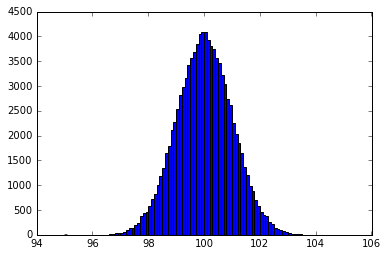

In [221]:
n,bins,patches = plt.hist(cleansky(),np.arange(95,105,0.1))

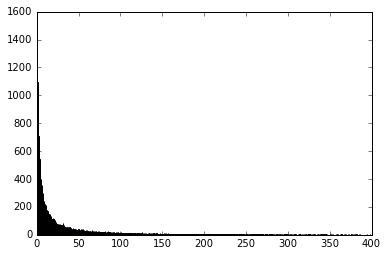

In [222]:
n,bins,patches = plt.hist(hotpix(),np.arange(0.,400.,0.1))

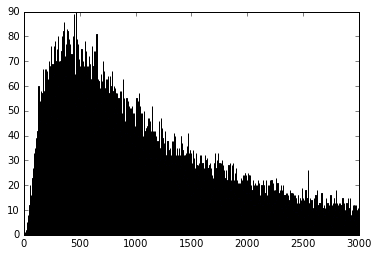

In [223]:
n,bins,patches = plt.hist(cosmicray(),np.arange(0.,3000.,1))

Construct a realization of the background, adding in the different components. Return both the floating point and the quantized version.

In [356]:
def realization(mean,sigma,offset,nsamp=1000000,hotpix_frac=0.1,cr_frac=0.05):
    nhot = int(nsamp*hotpix_frac)
    ncr = int(nsamp*hotpix_frac)
    ngood = nsamp-nhot-ncr
    goodsample =  cleansky(mean,sigma,offset,nsamp=ngood)
    hotsample = hotpix(nsamp=nhot) + cleansky(mean,sigma,offset,nsamp=nhot)
    crsample = cosmicray(nsamp=ncr) + cleansky(mean,sigma,offset,nsamp=ncr)
    floatsample = np.concatenate((goodsample,hotsample))
    intsample = (floatsample+0.5).astype(np.int32)
    return floatsample,intsample

In [357]:
def ofil(data,binsize=0.01):
    return ofiltsky.fitsky_ofilter(data,sigclip_sigma=None,binsize=binsize)[0]

In [358]:
def sigclip(data,niter=5,sigma=3.):
    mean, median, std = sigma_clipped_stats(data, sigma=sigma, iters=niter)
    return mean

Plot a realization of the background. Notice that the maximum is pretty high due to the presence of cosmic rays, but that the peak is right around the peak of the good-pixel values, with the hot pixels showing up as a tiny tail in the near wings of this distribution.

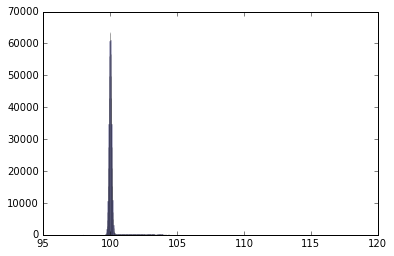

In [359]:
f,i = realization(100.,0.1,0.)
f.max()
foo = plt.hist(f,np.arange(98.,120.,0.02),alpha=0.2)

Now compare the estimates from three different techniques, operating on each of the floating point and the integer versions of the array: 
 * An unclipped mean
 * An unclipped median
 * ofilter

In [229]:
f0,i0 = realization(100.,1.,0.)
f1,i1 = realization(100.,1.,0.1)
f2,i2 = realization(100.,1.,0.2)
print "Mean of floating point versions: ", f0.mean(),f1.mean(),f2.mean()
print "Sigma-clipped Mean of floating point versions: ", sigclip(f0),sigclip(f1),sigclip(f2)
print "Mean of integer versions: ",i0.mean(),i1.mean(),i2.mean()
print "Sigma-clipped Mean of integer versions: ", sigclip(i0),sigclip(i1),sigclip(i2)
print "Median of float versions: ",np.median(f0),np.median(f1),np.median(f2)
print "Median of integer versions: ",np.median(i0),np.median(i1),np.median(i2)
print "Ofilt of floating point versions", ofil(f0),ofil(f1),ofil(f2)
print "Ofilt of integer point versions", ofil(i0),ofil(i1),ofil(i2)

Mean of floating point versions:  108.229147848 108.319912062 108.278923662
Sigma-clipped Mean of floating point versions:  100.05420705 100.149227382 100.252724255
Mean of integer versions:  108.22895 108.3201 108.278704444
Sigma-clipped Mean of integer versions:  100.04700964 100.142198474 100.24216495
Median of float versions:  100.14317959 100.23949204 100.341053137
Median of integer versions:  100.0 100.0 100.0
Ofilt of floating point versions 100.014991277 100.111901798 100.213239787
Ofilt of integer point versions 100.022519885 100.111895088 100.210373557


Results
----

For this particular case, ofilter is coming a bit closer to the peak value
of the goodpixel distribution than the sigma-clipped mean. It is, however, not entirely obvious which is a better sky estimate, since the pixels under the stars also have hot pixels, which is what is skewing the mean.

--------

Repeat the same test, varying the offset and plot the trend.

In [242]:
def repeat(realization,sigma=1.,nsamp=100000,val=100,binsize=0.1,plotmed=True):
    offset = np.arange(-1.,1.,0.02)
    fmean = offset*0.
    imean = offset*0.
    fmedian = offset*0.
    imedian = offset*0.
    fofilt = offset*0.
    iofilt = offset*0.
    for n,o in enumerate(offset):
        f,i = realization(val,sigma,o,nsamp=nsamp)
        fmean[n],fmedian[n],fofilt[n] = sigclip(f),np.median(f),ofil(f,binsize=binsize)
        imean[n],imedian[n],iofilt[n] = sigclip(i),np.median(i),ofil(i,binsize=binsize)
    plt.plot(offset,fmean-offset,'o',label='sigclip',alpha=0.3)
    if plotmed:
        plt.plot(offset,imedian-offset,'o',label='int median',alpha=0.3)
        plt.plot(offset,fmedian-offset,'s',label='float median',alpha=0.3)
    plt.plot(offset,fofilt-offset,'d',label='float ofilt',alpha=0.3)
    plt.plot(offset,iofilt-offset,'d',label='int ofilt',alpha=0.3)
    plt.legend()
#   return offset, fmean, imean, fmedian, imedian, fofilt, iofilt

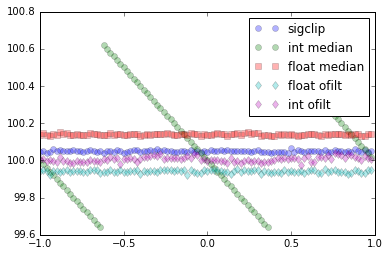

In [243]:
results = repeat(realization)

How does it compare relative to the standard error?
--------
Compare the offset to the expected standard-error-of-the-mean $\sigma/\sqrt(N)$.


In [365]:
def repeat_relative(realization,sigma=5.,nsamp=100000,val=100,binsize=0.01,plotmed=True):
    offset = np.arange(-1.,1.,0.02)
    fmean = offset*0.
    imean = offset*0.
    fmedian = offset*0.
    imedian = offset*0.
    fofilt = offset*0.
    iofilt = offset*0.
    stderr = sigma/np.sqrt(nsamp)
    for n,o in enumerate(offset):
        f,i = realization(val,sigma,o,nsamp=nsamp)
        fmean[n],fmedian[n],fofilt[n] = sigclip(f),np.median(f),ofil(f,binsize=binsize)
        imean[n],imedian[n],iofilt[n] = sigclip(i),np.median(i),ofil(i,binsize=binsize)
    plt.plot(offset,(fmean-val-offset)/stderr,'o',label='float sigcl ',alpha=0.3)
    plt.plot(offset,(imean-val-offset)/stderr,'o',label='int sigcl',alpha=0.3)
    if plotmed:
        plt.plot(offset,(imedian-val-offset)/stderr,'o',label='int median',alpha=0.3)
        plt.plot(offset,(fmedian-val-offset)/stderr,'s',label='float median',alpha=0.3)
    plt.plot(offset,(fofilt-val-offset)/stderr,'d',label='float ofilt',alpha=0.3)
    plt.plot(offset,(iofilt-val-offset)/stderr,'d',label='int ofilt',alpha=0.3)
#    plt.ylim(-100,100)
    plt.legend()

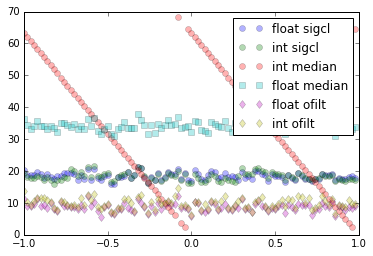

In [366]:
repeat_relative(realization)

So all of the estimates are biased high relative to the peak of the good pixels, but OFILT is coming the closest.

Let's see what happens if we vary the hot pixel fraction.

In [367]:
def repeathotpix(realization,sigma=1.,nsamp=100000,val=100,binsize=0.01,plotmed=True,offset=0.2):
    hotpixfrac = np.arange(0.,0.3,0.01)
    fmean = hotpixfrac*0.
    imean = hotpixfrac*0.
    fmedian = hotpixfrac*0.
    imedian = hotpixfrac*0.
    fofilt = hotpixfrac*0.
    iofilt = hotpixfrac*0.
    for n,o in enumerate(hotpixfrac):
        f,i = realization(val,sigma,o,nsamp=nsamp,hotpix_frac=o)
        fmean[n],fmedian[n],fofilt[n] = sigclip(f),np.median(f),ofil(f,binsize=binsize)
        imean[n],imedian[n],iofilt[n] = sigclip(i),np.median(i),ofil(i,binsize=binsize)
    plt.plot(hotpixfrac,imean-offset,'o',label='int sigclip',alpha=0.3)
    if plotmed:
        plt.plot(hotpixfrac,imedian-offset,'o',label='int median',alpha=0.3)
        plt.plot(hotpixfrac,fmedian-offset,'s',label='float median',alpha=0.3)
#   plt.plot(hotpixfrac,fofilt-offset,'d',label='float ofilt',alpha=0.3)
    plt.plot(hotpixfrac,iofilt-offset,'d',label='int ofilt',alpha=0.3)
    plt.legend(loc='upper left')
#   return offset, fmean, imean, fmedian, imedian, fofilt, iofilt

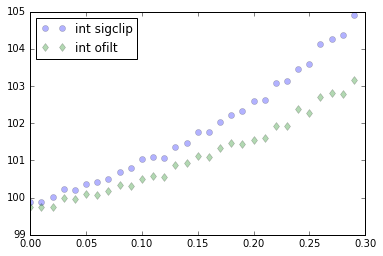

In [368]:
repeathotpix(realization,sigma=20.,binsize=0.01,plotmed=False)

...And if we vary the cosmic-ray fraction

In [369]:
def repeatcr(realization,sigma=1.,nsamp=100000,val=100,binsize=0.01,plotmed=True,offset=0.2):
    crfrac = np.arange(0.,0.2,0.005)
    fmean = crfrac*0.
    imean = crfrac*0.
    fmedian = crfrac*0.
    imedian = crfrac*0.
    fofilt = crfrac*0.
    iofilt = crfrac*0.
    for n,o in enumerate(crfrac):
        f,i = realization(val,sigma,o,nsamp=nsamp,cr_frac=o)
        fmean[n],fmedian[n],fofilt[n] = sigclip(f),np.median(f),ofil(f,binsize=binsize)
        imean[n],imedian[n],iofilt[n] = sigclip(i),np.median(i),ofil(i,binsize=binsize)
    plt.plot(crfrac,imean-offset,'o',label='int sigclip',alpha=0.3)
    if plotmed:
        plt.plot(crfrac,imedian-offset,'o',label='int median',alpha=0.3)
        plt.plot(crfrac,fmedian-offset,'s',label='float median',alpha=0.3)
#   plt.plot(hotpixfrac,fofilt-offset,'d',label='float ofilt',alpha=0.3)
    plt.plot(crfrac,iofilt-offset,'d',label='int ofilt',alpha=0.3)
    plt.legend(loc='upper left')
#   return offset, fmean, imean, fmedian, imedian, fofilt, iofilt

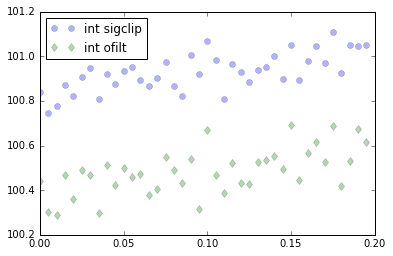

In [370]:
repeatcr(realization,sigma=20.,binsize=0.01,plotmed=False)

Simulated photometry
-----------

Add hypothetical stars each "subtending" 5 pixels with a total flux of 1000 and no scatter. 
Subtract from each star the background estimate computed from 50 pixel by one or the other technique. 
Do this lots of times and see which if any technique gives the best approximation to the true flux.

In [371]:
def fakestars(flux=1000,npix=5,nbkgd=50,niter=50000,floatint=1):
    fi = floatint
    fnpix = 1.*npix # Make sure background is floating point
    background = realization(100.,5.,0.2,nsamp=1.2*niter*nbkgd)[fi]
    f_sigclip = np.zeros((niter),dtype=np.float64) # estimated flux using sigmaclipped mean bkgd
    f_ofilt = np.zeros((niter),dtype=np.float64) # estimated flux using OFILT bkgd
    for i in range(niter):
        source = flux + realization(100.,5.,0.2,nsamp=npix)[fi].sum()
        bi = i*nbkgd
        bkgd = background[bi:bi+nbkgd]
        b_sigclip = sigclip(bkgd)*fnpix
        b_ofilt = ofil(bkgd,binsize=0.1)*fnpix
        f_sigclip[i] = source - b_sigclip
        f_ofilt[i] = source - b_ofilt
    return f_sigclip, f_ofilt

Try this in the floating point version (i.e. no quantization noise)

Clipped mean measured flux using sigclipped background:  999.916019148
Clipped mean measured flux using OFILT background:  1000.21434127
OFILT measured flux using OFILT background:  1000.52374705


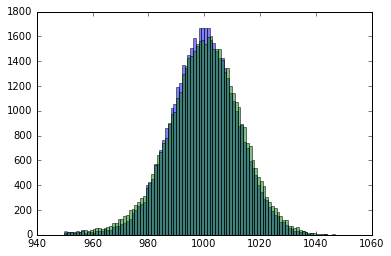

In [372]:
f_sigclip,f_ofilt = fakestars(floatint=0)
n,bins,patches = plt.hist(f_sigclip,np.arange(950.,1050,1),alpha=0.5,color='b')
n,bins,patches = plt.hist(f_ofilt,np.arange(950.,1050,1),alpha=0.5,color='g')
print "Clipped mean measured flux using sigclipped background: ",sigclip(f_sigclip)
print "Clipped mean measured flux using OFILT background: ",sigclip(f_ofilt)
print "OFILT measured flux using OFILT background: ",ofil(f_ofilt)

Try the integer version (i.e. with quantization noise)

Clipped mean measured flux using sigclipped background:  999.961703702
Clipped mean measured flux using OFILT background:  999.8625475
OFILT measured flux using OFILT background:  1000.19245971


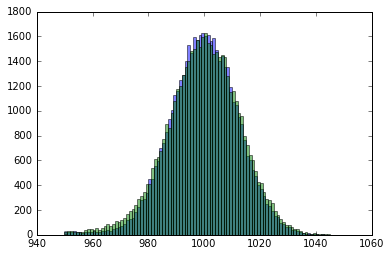

In [373]:
f_sigclip,f_ofilt = fakestars(floatint=1)
n,bins,patches = plt.hist(f_sigclip,np.arange(950.,1050,1),alpha=0.5,color='b')
n,bins,patches = plt.hist(f_ofilt,np.arange(950.,1050,1),alpha=0.5,color='g')
print "Clipped mean measured flux using sigclipped background: ",sigclip(f_sigclip)
print "Clipped mean measured flux using OFILT background: ",sigclip(f_ofilt)
print "OFILT measured flux using OFILT background: ",ofil(f_ofilt)

Conclusion
----

If the goal is to estimate the main peak of the background histogram, 
then in this case OFILT is a little bit better than a clipped mean. However,
if the goal is to subtract the background, then the clipped mean is a little
bit better. Both are doing quite well in this difficult case, returning 
photometry within 0.02% for OFILT and 0.004% for the clipped mean background
subtraction. 

Version info (output of cell below):

```
Versions:
python:  sys.version_info(major=2, minor=7, micro=11, releaselevel='final', serial=0)
astropy:  1.1.2
scipy:  0.17.1
```

In [376]:
# Version info
import sys
import astropy
import scipy
print "Versions:"
print "python: ",sys.version_info
print "astropy: ",astropy.__version__
print "scipy: ",scipy.__version__

Versions:
python:  sys.version_info(major=2, minor=7, micro=11, releaselevel='final', serial=0)
astropy:  1.1.2
scipy:  0.17.1
